<a href="https://colab.research.google.com/github/an-eve/restricted-bolzmann-machine/blob/main/dbn_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion-MNIST Exploration with Deep Belief Networks (DBN)

Author: Anna Putina
2081379

Cognition and Computation

## Imports and Dataset Uploading

In [1]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/an-eve/restricted-bolzmann-machine/main/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [2]:
%%capture
get_dbn_library()

In [95]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
import torch.nn.functional as F
import torchvision.transforms as transforms
import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from skimage.util import random_noise

from DBN import DBN

Choose GPU when available

In [4]:
print(torch.cuda.is_available())
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

True
cuda


Uploading **Fasion MNIST** dataset:

The dataset is a collection of 70,000 grayscale images (28x28 pixels) of clothing items, designed as a drop-in replacement for the classic MNIST dataset. It consists of 10 classes, including items like T-shirts, trousers, dresses, and sneakers, with 60,000 images for training and 10,000 for testing.

In [5]:
# Load Fashion-MNIST dataset
fsh_mnist_train = tv.datasets.FashionMNIST(root="./data", train=True, download=True)
fsh_mnist_test = tv.datasets.FashionMNIST(root="./data", train=False, download=True)

# Move data to the selected device
train_images = fsh_mnist_train.data.to(dtype=torch.float32, device=device) / 255
test_images = fsh_mnist_test.data.to(dtype=torch.float32, device=device) / 255

train_labels = fsh_mnist_train.targets.to(device)
test_labels = fsh_mnist_test.targets.to(device)

# Print dataset shapes
print("Train images shape:", train_images.shape)
print("Test images shape:", test_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.5MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 166kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.11MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 3.59MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Train images shape: torch.Size([60000, 28, 28])
Test images shape: torch.Size([10000, 28, 28])
Train labels shape: torch.Size([60000])
Test labels shape: torch.Size([10000])


Show some samples

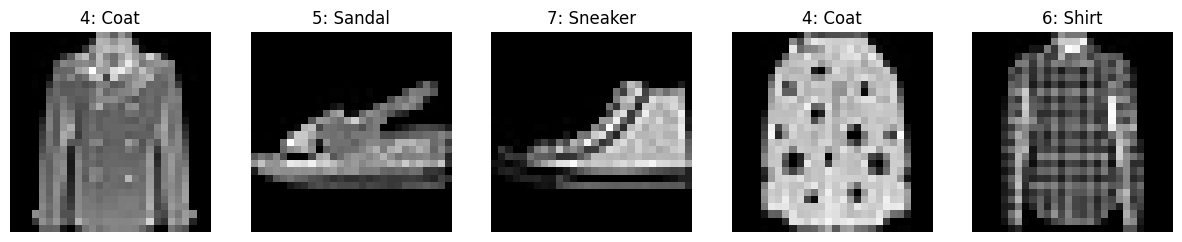

In [6]:
# Class labels for Fashion-MNIST
class_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

num_samples = 5
indices = torch.randint(0, train_images.shape[0], (num_samples,))

sample_images = train_images[indices].cpu().numpy()
sample_labels = train_labels[indices].cpu().numpy()

fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i in range(num_samples):
    axes[i].imshow(sample_images[i], cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"{sample_labels[i]}: {class_labels[sample_labels[i]]}")

plt.show()

## Deep Belief Network

A Deep Belief Network (DBN) is a type of deep neural network composed of multiple stacked Restricted Boltzmann Machines (RBMs), where each layer learns a probabilistic representation of the input in an unsupervised manner. Once pretraining is complete, the DBN can be fine-tuned using supervised learning techniques.

In [7]:
dbn_fashion = DBN(visible_units=28*28,          # dimensionality of the sensory data
                hidden_units=[400, 600, 900], # size of hidden layers
                k=1,                          # reconstruction steps in Contrastive Divergence
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.4,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

Training the model

In [8]:
num_epochs = 80
batch_size = 125

dbn_fashion.train_static(
    train_images,
    train_labels,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.8703     |0.0845       |314.4443   |6.1892     |
|20    |1.7399     |0.0777       |291.2602   |4.8791     |
|30    |1.7018     |0.0787       |287.6808   |4.9875     |
|40    |1.6889     |0.0765       |283.3126   |5.8878     |
|50    |1.6840     |0.0771       |283.5994   |5.2084     |
|60    |1.6750     |0.0773       |281.3261   |4.8281     |
|70    |1.6800     |0.0775       |282.5764   |4.8610     |
|80    |1.6756     |0.0755       |279.2471   |5.2834     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.0963     |0.0376       |148.5857   |2.3516     |
|20    |1.0182     |0.0335       |137.2433   |2.4049     |
|30    |1.0025     |0.0332       |134.6210   |2.4942     |
|40    |0.9891     |0.0322       |132.4409   |2.3423     |
|50    |0.9829     |0.0330       |130.7538   |1.9419     |
|60    |0.9778     |0.0323       

## Visualizing receptive fields

After training a Deep Belief Network (DBN), the learned weights between the input and hidden layers represent the features the model has detected. Visualizing these receptive fields as grayscale images helps us understand what patterns or parts of an image activate specific neurons, aiding in feature analysis, debugging, and model improvement.

To do this, we extract the weight vectors, reshape them into the same size as input images (28×28 for Fashion-MNIST), and plot them. Since different neurons may learn weights at varying scales, we normalize them using MinMaxScaler to ensure comparability, and applying a threshold can reduce noise and highlight key features.

For deeper hidden layers, the weights do not have the same dimensionality as the input images. To visualize them, we must project these weight vectors into a 784-dimensional space (28×28). There are multiple ways to do this; for simplicity, we use a linear projection to map these higher-layer weights back to the input space, making them interpretable as images.

In [17]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights

def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

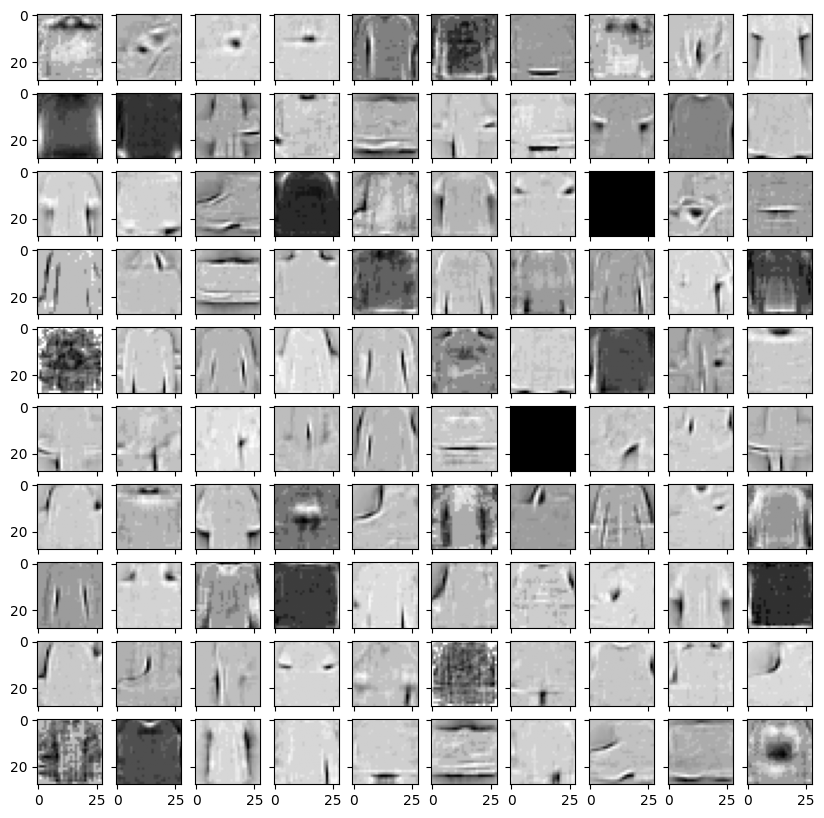

In [18]:
w1 = get_weights(dbn_fashion, layer=0)
w1 = apply_threshold(w1, 0.1)
w1 = apply_min_max_scaler(w1)

plot_layer_receptive_fields(w1.T)

Hidden layers

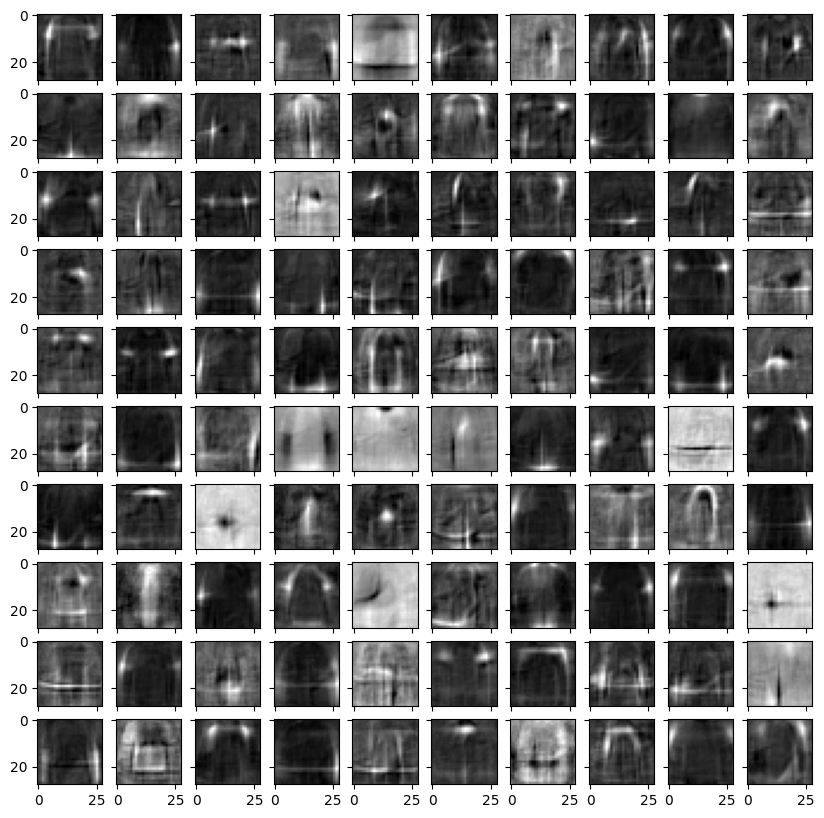

In [11]:
w1 = get_weights(dbn_fashion, layer=0)
w2 = get_weights(dbn_fashion, layer=1)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)

w_product = (w1 @ w2)  # here we do the projection
w_product = apply_threshold(w_product, 0.1)
w_product = apply_min_max_scaler(w_product)

plot_layer_receptive_fields(w_product.T)

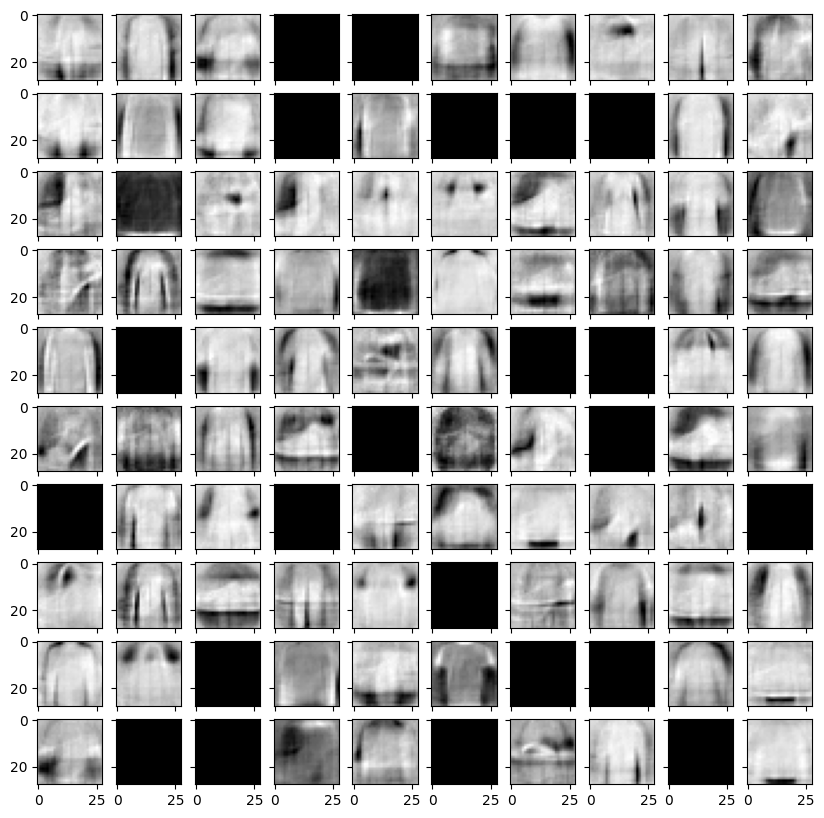

In [12]:
w1 = get_weights(dbn_fashion, layer=0)
w2 = get_weights(dbn_fashion, layer=1)
w3 = get_weights(dbn_fashion, layer=2)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)
w3 = apply_threshold(w3, 0.1)

w_product_12 = (w1 @ w2)  # here we do the projection
w_product_23 = (w_product_12 @ w3)  # here we do the projection
w_product_23 = apply_threshold(w_product_23, 0.1)
w_product_23 = apply_min_max_scaler(w_product_23)

plot_layer_receptive_fields(w_product_23.T)

## Clustering internal representations

After training a Deep Belief Network (DBN), we analyze how it organizes different classes by clustering their internal representations. Instead of using individual activations, we compute centroids (mean activations) for each class, reducing noise and summarizing the learned features.

To visualize class relationships, we apply hierarchical clustering and represent the results using a dendrogram. This shows which classes have similar feature representations—closely clustered classes share learned patterns, while distant ones indicate distinct features. If expected groups (e.g., "Sneaker" and "Ankle Boot") cluster together, the DBN has captured meaningful similarities. If unrelated classes are close, it may suggest confusion in feature learning. This analysis helps evaluate and refine the model's feature representations.

In [19]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_fashion.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

In [20]:
hidden_repr_1 = get_kth_layer_repr(train_images, 0, device)
hidden_repr_2 = get_kth_layer_repr(hidden_repr_1, 1, device)
hidden_repr_3 = get_kth_layer_repr(hidden_repr_2, 2, device)
print(hidden_repr_1.shape)
print(hidden_repr_2.shape)
print(hidden_repr_3.shape)

torch.Size([60000, 400])
torch.Size([60000, 600])
torch.Size([60000, 900])


In [21]:
def get_mask(label):  # we use this function to filter by class
  labels = train_labels.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_repr):
  hidden_repr_np = hidden_repr.cpu().numpy()
  return {
    label: hidden_repr_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(10)
  }

def get_hidden_reprs_matrix(hidden_repr):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_repr)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(10)])

def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

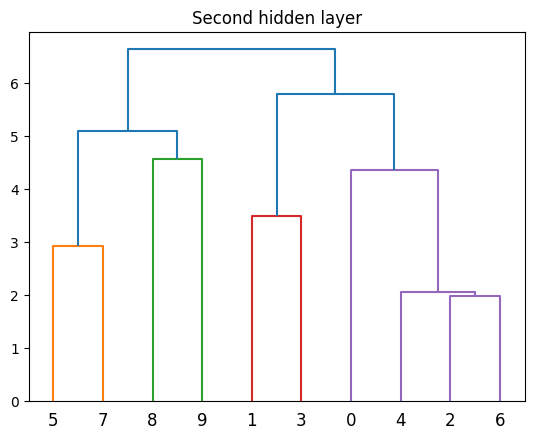

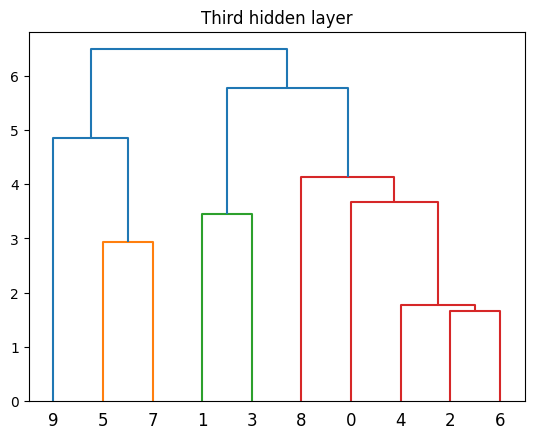

In [22]:
mean_hidd_repr_matrix_2 = get_hidden_reprs_matrix(hidden_repr_2)
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_3)

plot_dendrogram(mean_hidd_repr_matrix_2, 'Second hidden layer')
plot_dendrogram(mean_hidd_repr_matrix_3, 'Third hidden layer')

In [23]:
# Function to show closest clusters
def plot_cluster_examples(cluster_classes, num_examples=5):
    fig, axes = plt.subplots(2, num_examples, figsize=(10, 5))

    for row, class_label in enumerate(cluster_classes):
        mask = get_mask(class_label)  # Get all images of the class
        class_images = train_images[mask][:num_examples].cpu().numpy()  # Take some examples

        print(f"Class {class_label}: {class_labels[class_label]}")  # Print class name

        for col in range(num_examples):
            axes[row, col].imshow(class_images[col], cmap="gray")
            axes[row, col].axis("off")
            if col == 0:
                axes[row, col].set_title(f"{class_labels[class_label]} ({class_label})")

    plt.show()


Class 2: Pullover
Class 6: Shirt


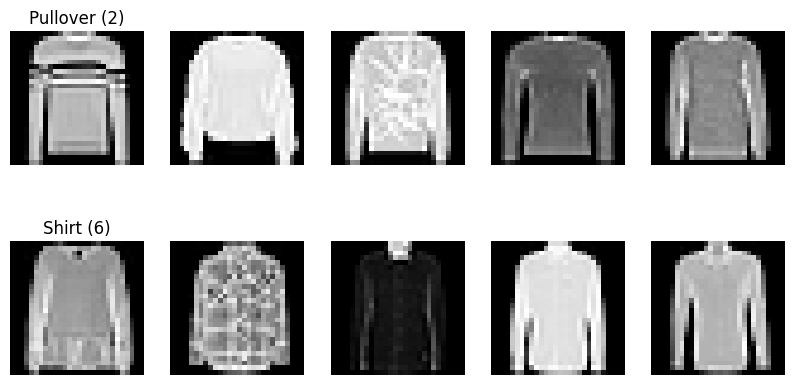

In [ ]:
plot_cluster_examples([2, 6], num_examples=5)

Class 5: Sandal
Class 7: Sneaker


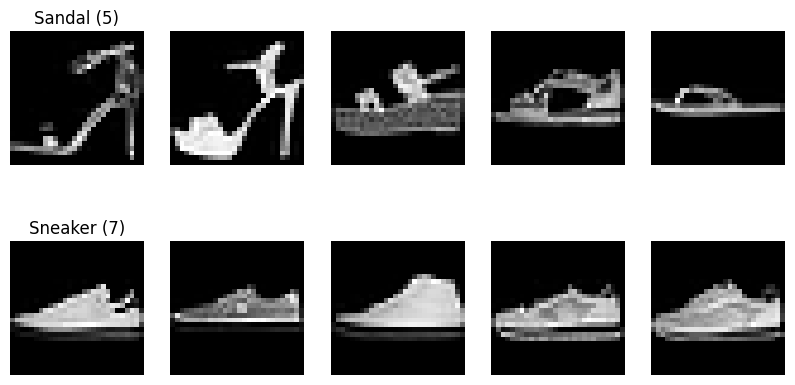

In [ ]:
plot_cluster_examples([5, 7], num_examples=5)

Indead, we see that the closest clusters represent similar items.

## Linear read-out

A linear readout is a technique to assess the quality of hidden representations in a Deep Belief Network (DBN) by training a simple linear classifier on them. If the classifier achieves high accuracy, it indicates that the hidden layer retains meaningful and discriminative features for classification.

To apply this, we compute activations at each hidden layer and use them as input for a linear classifier. If accuracy improves with deeper layers, the DBN is effectively extracting useful features. A drop in accuracy at later layers may suggest that representations become too abstract or lose discriminative power. This method provides a quick way to evaluate whether each layer contributes to meaningful feature learning.

In [24]:
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 10)

  def forward(self, x):
    return self.linear(x)

In [25]:
layer_size = dbn_fashion.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_fashion.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_fashion.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

Training

In [26]:
def train_linear(linear, hidden_reprs, epochs = 1000):
  optimizer = torch.optim.SGD(linear.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = linear(hidden_reprs).squeeze()
    targets = train_labels.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [27]:
train_linear(linear1, hidden_repr_1)
train_linear(linear2, hidden_repr_2)
train_linear(linear3, hidden_repr_3)


epoch :   1/1000, loss = 2.3648
epoch : 101/1000, loss = 0.9276
epoch : 201/1000, loss = 0.7220
epoch : 301/1000, loss = 0.6401
epoch : 401/1000, loss = 0.5936
epoch : 501/1000, loss = 0.5623
epoch : 601/1000, loss = 0.5395
epoch : 701/1000, loss = 0.5217
epoch : 801/1000, loss = 0.5074
epoch : 901/1000, loss = 0.4955
epoch :   1/1000, loss = 2.2917
epoch : 101/1000, loss = 0.8024
epoch : 201/1000, loss = 0.6505
epoch : 301/1000, loss = 0.5887
epoch : 401/1000, loss = 0.5521
epoch : 501/1000, loss = 0.5270
epoch : 601/1000, loss = 0.5083
epoch : 701/1000, loss = 0.4936
epoch : 801/1000, loss = 0.4817
epoch : 901/1000, loss = 0.4717
epoch :   1/1000, loss = 2.3096
epoch : 101/1000, loss = 0.8559
epoch : 201/1000, loss = 0.6769
epoch : 301/1000, loss = 0.6056
epoch : 401/1000, loss = 0.5646
epoch : 501/1000, loss = 0.5370
epoch : 601/1000, loss = 0.5167
epoch : 701/1000, loss = 0.5009
epoch : 801/1000, loss = 0.4882
epoch : 901/1000, loss = 0.4777


Evaluation

In [28]:
hidden_repr_1_test = get_kth_layer_repr(train_images, 0, device)
hidden_repr_2_test = get_kth_layer_repr(hidden_repr_1_test, 1, device)
hidden_repr_3_test = get_kth_layer_repr(hidden_repr_2_test, 2, device)

# compute the classifier predictions:
predictions_test1 = linear1(hidden_repr_1_test)
predictions_test2 = linear2(hidden_repr_2_test)
predictions_test3 = linear3(hidden_repr_3_test)

In [29]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [30]:
print(compute_accuracy(predictions_test1, train_labels))
print(compute_accuracy(predictions_test2, train_labels))
print(compute_accuracy(predictions_test3, train_labels))

0.8361999988555908
0.8411166667938232
0.83965003490448


The slight accuracy increase (**0.837 → 0.841 → 0.840**) suggests that deeper layers provide **minimal additional disentanglement**. Most useful features are learned early, and deeper layers do not significantly improve class separability. This indicates that the DBN may not be refining representations effectively at deeper levels. Further analysis or architectural adjustments may be needed to enhance hierarchical feature learning.

## Comparison with a feed-forward neural network

This comparison tests **unsupervised pretraining (DBN + linear classifier)** against **end-to-end supervised learning (FNN)**. It evaluates whether the **DBN’s learned representations** are as effective as those learned **directly through supervision**. A stronger DBN suggests unsupervised learning captures meaningful features, while a better FNN indicates direct supervision is more beneficial.

In [31]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 10)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

In [32]:
ffnn = Feedforward(400, 600, 900).to(device)

In [33]:
train_linear(ffnn, train_images.reshape((60000, 784)), 1000)

epoch :   1/1000, loss = 2.3021
epoch : 101/1000, loss = 1.3468
epoch : 201/1000, loss = 0.9064
epoch : 301/1000, loss = 0.7624
epoch : 401/1000, loss = 0.6724
epoch : 501/1000, loss = 0.6078
epoch : 601/1000, loss = 0.5770
epoch : 701/1000, loss = 0.5448
epoch : 801/1000, loss = 0.5069
epoch : 901/1000, loss = 0.4946


In [34]:
predictions_ffnn = ffnn(test_images.reshape((10000, 784)))
compute_accuracy(predictions_ffnn, test_labels)

0.8159999847412109

The accuracy is a little lower for FFNN.

Confusion matrixes for models:

In [36]:
def plot_confusion_matrix(model, data, targets, model_type="FFNN", dbn_layer=None):
    """Plots the confusion matrix for FFNN or DBN models, allowing DBN layer selection."""

    # Reshape and process data based on model type
    if model_type == "FFNN":
        predictions = model(data.reshape((data.shape[0], 784)))  # Flatten for FFNN

    elif model_type == "DBN":
        if dbn_layer is None:
            raise ValueError("For DBN, you must specify dbn_layer as 0, 1, or 2.")

        # Compute the hidden representation at the specified DBN layer
        data = data.view(data.shape[0], -1)
        if dbn_layer == 0:
            hidden_repr, _ = model.rbm_layers[0].to_hidden(data)
            predictions = linear1(hidden_repr)
        elif dbn_layer == 1:
            hidden_repr_1, _ = model.rbm_layers[0].to_hidden(data)
            hidden_repr, _ = model.rbm_layers[1].to_hidden(hidden_repr_1)
            predictions = linear2(hidden_repr)
        elif dbn_layer == 2:
            hidden_repr_1, _ = model.rbm_layers[0].to_hidden(data)
            hidden_repr_2, _ = model.rbm_layers[1].to_hidden(hidden_repr_1)
            hidden_repr, _ = model.rbm_layers[2].to_hidden(hidden_repr_2)
            predictions = linear3(hidden_repr)
        else:
            raise ValueError("Invalid dbn_layer. Choose 0, 1, or 2.")

    # Convert probabilities to predicted class indices
    predictions = predictions.max(axis=1).indices

    # Compute confusion matrix
    conf_mat = confusion_matrix(
        targets.cpu().numpy(),
        predictions.cpu().detach().numpy(),
        labels=np.unique(targets.cpu().numpy()),
        normalize='true'
    )

    # Plot confusion matrix
    _, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(
        conf_mat,
        annot=True,
        fmt='.2f',
        xticklabels=np.unique(targets.cpu().numpy()),
        yticklabels=np.unique(targets.cpu().numpy())
    )

    plt.ylabel('Actual', fontsize=18)
    plt.xlabel('Predicted', fontsize=18)
    title = f'Confusion Matrix - {model_type}' if model_type == "FFNN" else f'Confusion Matrix - DBN ({dbn_layer})'
    plt.title(title, fontsize=18)
    plt.show()

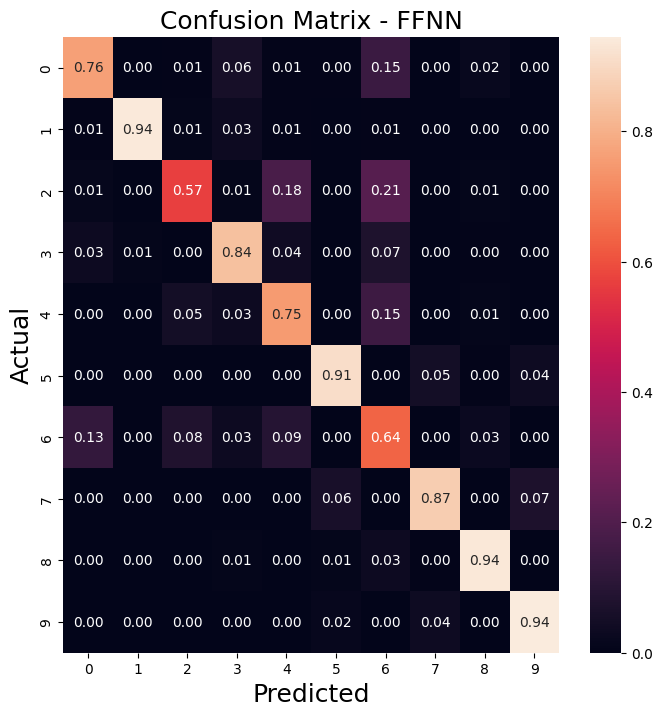

In [37]:
plot_confusion_matrix(ffnn, test_images, test_labels, model_type="FFNN")  # For FFNN

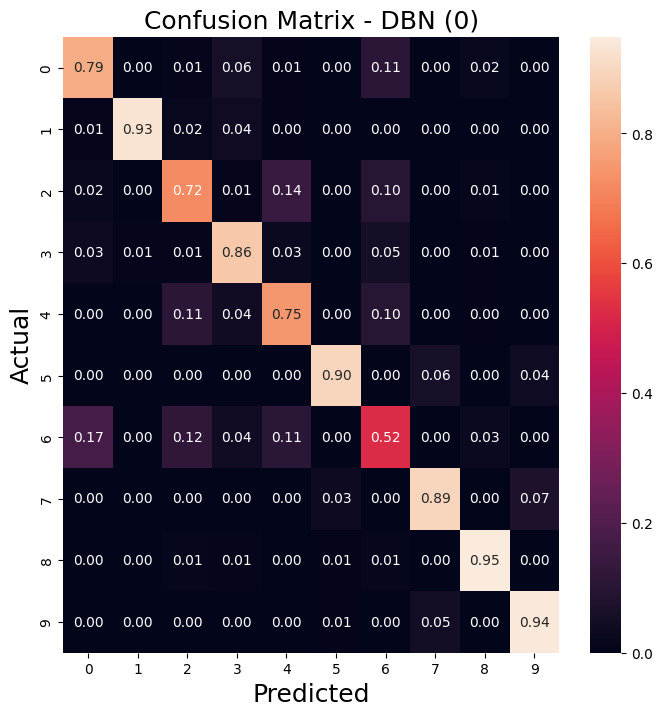

In [38]:
plot_confusion_matrix(dbn_fashion, test_images, test_labels, model_type="DBN", dbn_layer=0)  # For DBN

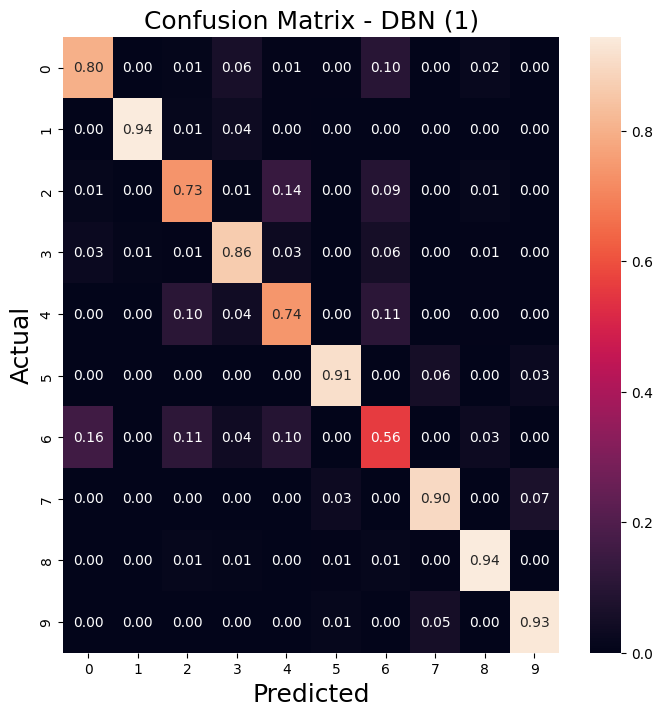

In [39]:
plot_confusion_matrix(dbn_fashion, test_images, test_labels, model_type="DBN", dbn_layer=1)  # For DBN

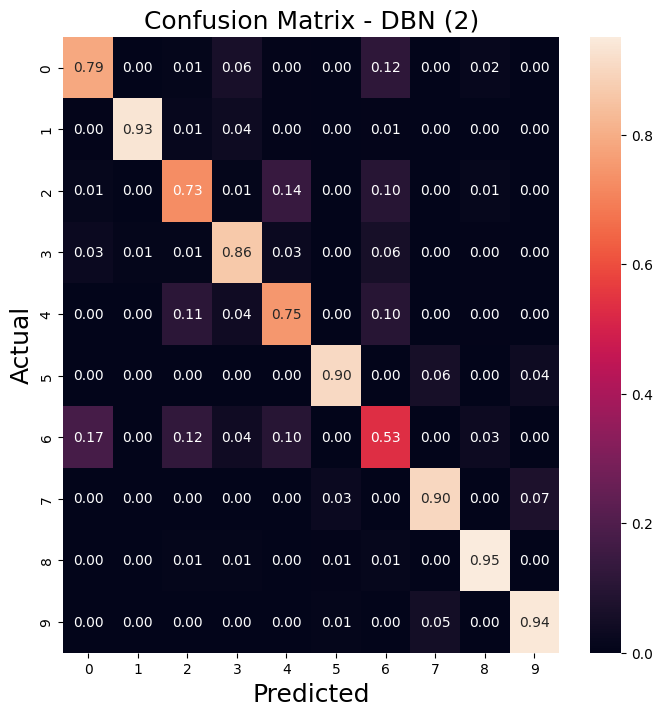

In [40]:
plot_confusion_matrix(dbn_fashion, test_images, test_labels, model_type="DBN", dbn_layer=2)  # For DBN

A confusion matrix compares actual and predicted labels, showing how well a model distinguishes classes. The diagonal values indicate correct predictions, while off-diagonal values highlight misclassifications.

For FFNN vs. DBN layers, deeper DBN layers should improve accuracy if representations become more disentangled. If FFNN outperforms DBN, end-to-end supervised learning is more effective. Large misclassifications suggest overlapping features between classes, helping identify model weaknesses.

## Robustness to noise

Testing robustness to noise evaluates how well a model maintains classification accuracy when the input data is perturbed. By injecting noise into images, we assess whether the DBN and FFNN have learned stable and meaningful representations or if their predictions degrade quickly with minor distortions.

This mimics psychophysical experiments, where human perception is tested under uncertain conditions. By plotting a psychometric curve, we measure how classification accuracy decreases as noise increases. A more gradual decline indicates greater robustness, meaning the model relies on essential features rather than fragile details.

In [41]:
def inject_noise(data, noise_level):
    noise = torch.randn_like(data) * noise_level
    noisy_data = data + noise
    return noisy_data

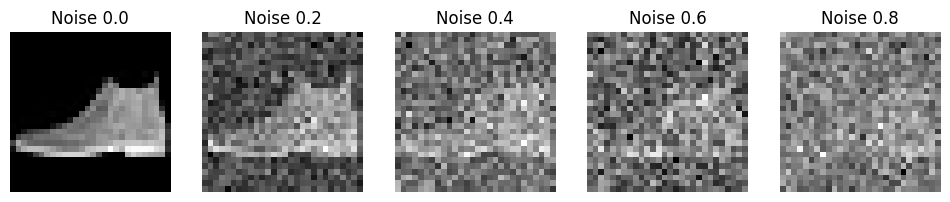

In [43]:
# Define different noise levels
noise_levels = [0.0, 0.2, 0.4, 0.6, 0.8]

# Plot images with increasing noise
fig, axes = plt.subplots(1, len(noise_levels), figsize=(12, 3))

for i, noise_level in enumerate(noise_levels):
    noisy_images = inject_noise(test_images, noise_level)
    axes[i].imshow(noisy_images[0].reshape(28, 28).cpu(), cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"Noise {noise_level}")

plt.show()


We will now generate hidden representations for the noisy images using the DBN. Then, we will classify these noisy inputs using the read-out classifiers that were trained on noise-free representations.

In [44]:
def get_accuracy_values_at_noise_level(noise_level):

  data_test_with_noise = inject_noise(test_images, noise_level)  # first, let's create noisy test images

  hidden_repr_1_noisy = get_kth_layer_repr(data_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_2_noisy = get_kth_layer_repr(hidden_repr_1_noisy, 1, device)
  hidden_repr_3_noisy = get_kth_layer_repr(hidden_repr_2_noisy, 2, device)

  predictions_first_hidden_noisy = linear1(hidden_repr_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_3_noisy)

  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, test_labels)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, test_labels)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, test_labels)

  ### TASK: repeat a similar process for the feed-forward model (NB: make sure you reshape the input data appropriately!)
  predictions_ffnn_noisy = ffnn(data_test_with_noise.reshape((10000, 784)))
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy, test_labels)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn


In [45]:
acc = get_accuracy_values_at_noise_level(0.3);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])
print("Accuracy of FF network : %.3f" % acc[3])

Accuracy of H1 read-out: 0.799
Accuracy of H2 read-out: 0.814
Accuracy of H3 read-out: 0.817
Accuracy of FF network : 0.784


Check different noise levels:

In [46]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

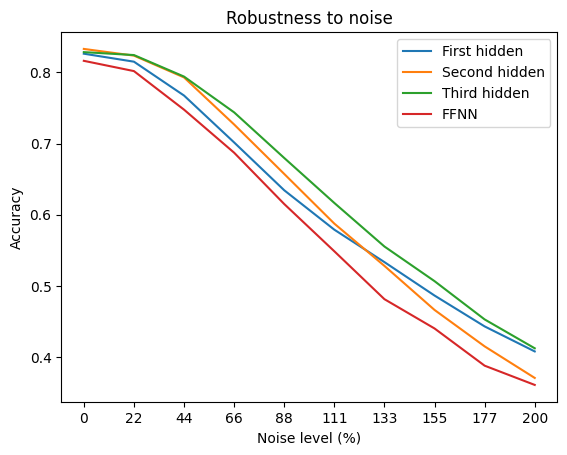

In [47]:
noise_levels = np.linspace(0,2,10)
plot_noise_robustness_curves(noise_levels)

As noise increases, classification accuracy drops for all models. Deeper DBN layers (green, orange) are more robust, while FFNN (red) degrades faster, showing higher sensitivity to noise. At extreme noise levels, all models perform similarly. This suggests unsupervised pretraining (DBN) learns more stable features, making it more resilient to noise.

## Perturbing the models with adversarial attacks


Adversarial attacks test model robustness by introducing small perturbations that force misclassification. This helps assess feature sensitivity, revealing whether the model relies on fragile or meaningful patterns. If accuracy drops significantly, the model is vulnerable; if it resists, it has better adversarial robustness.

Here the adversarial attack is defined using the Fast Gradient Sign Method. It perturbs the input by adding noise in the direction of the gradient of the loss with respect to the input, scaled by a small factor ε. This forces the model to misclassify while keeping the changes minimal.

In [48]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

In [53]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_fashion, readout):
        super().__init__()
        self.readout = readout
        self.readout_level = 2
        self.dbn_fashion = dbn_fashion
        self._require_grad()

    def _require_grad(self):
      for rbm in self.dbn_fashion.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM activations
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_fashion.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readout.forward(hidden_states[self.readout_level])

In [54]:
dbn_with_readout = DBNWithReadOut(dbn_fashion, linear3)

The example of adversarial attack:

DBN:

In [55]:
attacked_model = dbn_with_readout

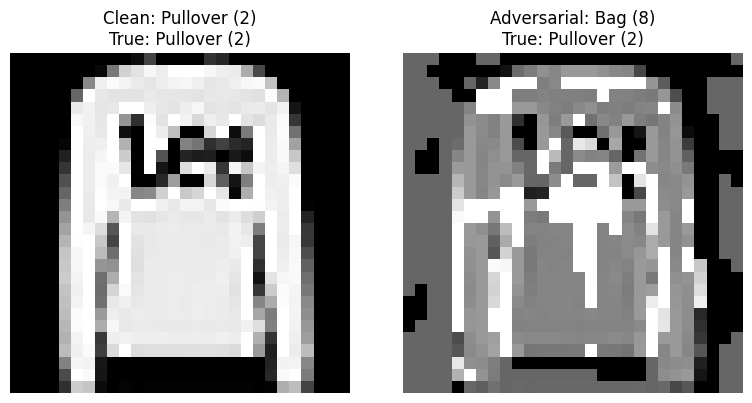

In [56]:
# Select test sample
test_sample_idx = 1
test_image = test_images[test_sample_idx].reshape(1, 784)
test_label = test_labels[test_sample_idx].item()
test_label_name = class_labels[test_label]  # Get true class name

# Get model prediction on clean image
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
clean_prediction = torch.argmax(model_outputs).item()
clean_prediction_name = class_labels[clean_prediction]  # Get predicted class name

# Define attack strength
epsilon = 0.4
test_image_label = test_labels[test_sample_idx].unsqueeze(0)
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)
attacked_model.zero_grad()
loss_value.backward(retain_graph=True)
image_grad = test_image.grad.data

# Generate adversarial image
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

# Get model prediction on perturbed image
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
perturbed_prediction = torch.argmax(model_outputs).item()
perturbed_prediction_name = class_labels[perturbed_prediction]  # Get adversarial prediction class name

# Plot clean and adversarial images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Clean Image
axes[0].imshow(test_image.detach().reshape(28, 28).cpu(), cmap="gray")
axes[0].set_title(f"Clean: {clean_prediction_name} ({clean_prediction})\nTrue: {test_label_name} ({test_label})")
axes[0].axis("off")

# Adversarial Image
axes[1].imshow(perturbed_image.detach().reshape(28, 28).cpu(), cmap="gray")
axes[1].set_title(f"Adversarial: {perturbed_prediction_name} ({perturbed_prediction})\nTrue: {test_label_name} ({test_label})")
axes[1].axis("off")

plt.tight_layout()
plt.show()


FFNN:

In [57]:
attacked_model = ffnn

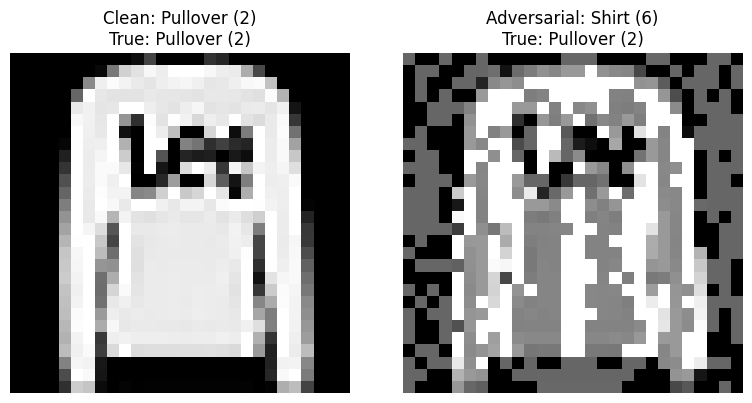

In [58]:
# Select test sample
test_sample_idx = 1
test_image = test_images[test_sample_idx].reshape(1, 784)
test_label = test_labels[test_sample_idx].item()
test_label_name = class_labels[test_label]  # Get true class name

# Get model prediction on clean image
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
clean_prediction = torch.argmax(model_outputs).item()
clean_prediction_name = class_labels[clean_prediction]  # Get predicted class name

# Define attack strength
epsilon = 0.4
test_image_label = test_labels[test_sample_idx].unsqueeze(0)
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)
attacked_model.zero_grad()
loss_value.backward(retain_graph=True)
image_grad = test_image.grad.data

# Generate adversarial image
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

# Get model prediction on perturbed image
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
perturbed_prediction = torch.argmax(model_outputs).item()
perturbed_prediction_name = class_labels[perturbed_prediction]  # Get adversarial prediction class name

# Plot clean and adversarial images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Clean Image
axes[0].imshow(test_image.detach().reshape(28, 28).cpu(), cmap="gray")
axes[0].set_title(f"Clean: {clean_prediction_name} ({clean_prediction})\nTrue: {test_label_name} ({test_label})")
axes[0].axis("off")

# Adversarial Image
axes[1].imshow(perturbed_image.detach().reshape(28, 28).cpu(), cmap="gray")
axes[1].set_title(f"Adversarial: {perturbed_prediction_name} ({perturbed_prediction})\nTrue: {test_label_name} ({test_label})")
axes[1].axis("off")

plt.tight_layout()
plt.show()


It is difficult for the models to identify the correct class of attacked images.

### Resisting to adversarial attack

We compare how well our two models resist adversarial attacks.  

Additionally, we will evaluate the DBN’s ability to mitigate the attack’s impact by performing a "top-down" reconstruction step, where we reconstruct the input from the last hidden layer back to the visible units and then forward to the hidden representation again.

In [63]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0  # count number of correct classifications
    print_reconstruction = num_steps > 0  # if we request for top-down reconstruction, show the resulting image

    for data, target in tqdm.tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # we need to get the gradient to perform the attack

        output = model.forward(data)  # forward pass through the model

        init_pred = torch.argmax(output)  # prediction before the attack

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          plt.show()

        loss_value = torch.nn.functional.cross_entropy(output, target) # get loss value
        model.zero_grad()
        loss_value.backward()
        data_grad = data.grad.data  # collect the gradient with respect to the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)  # call the attack function previously defined

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()

        # If requested, reconstruct the input iterating bottom-up and top-down sampling
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_fashion.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [71]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.FashionMNIST(
        root='data/',
        train=False,
        download=True,
        transform=tv.transforms.ToTensor()
    ),
    batch_size=100,
    shuffle=True
)

FFNN:

In [79]:
final_acc = test_robustness_to_attack(ffnn, device, test_loader, epsilon=0.1, num_steps=0)

100%|██████████| 100/100 [00:01<00:00, 85.89it/s]


Epsilon: 0.1
Test Accuracy: 17.38%



DBN:

In [80]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

100%|██████████| 100/100 [00:01<00:00, 60.55it/s]


Epsilon: 0.1
Test Accuracy: 40.13%



DBN with one step of top-down reconstruction from the generative model:

  0%|          | 0/100 [00:00<?, ?it/s]


Here's the original sample:



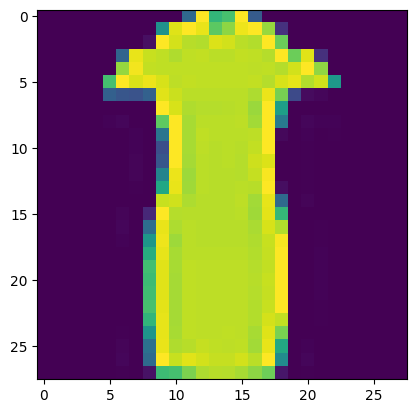


Here's a perturbed sample:



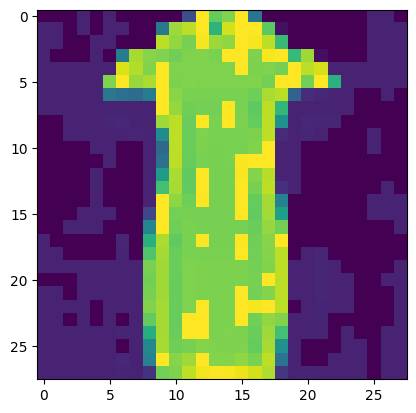


Here's what a 1-steps reconstructed sample looks like:



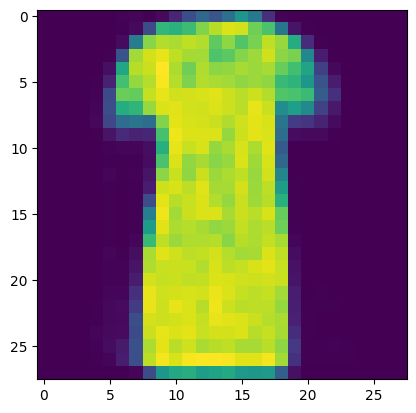

100%|██████████| 100/100 [00:02<00:00, 49.28it/s]


Epsilon: 0.1
Test Accuracy: 40.13%



In [81]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=1)

DBN with two steps of top-down reconstruction from the generative model:

  0%|          | 0/100 [00:00<?, ?it/s]


Here's the original sample:



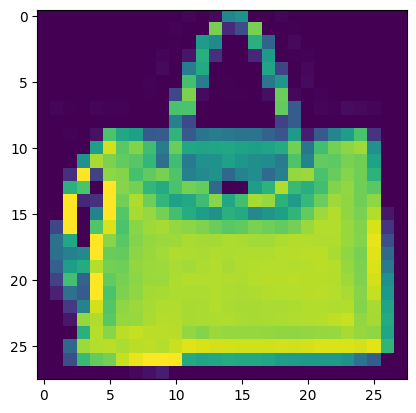


Here's a perturbed sample:



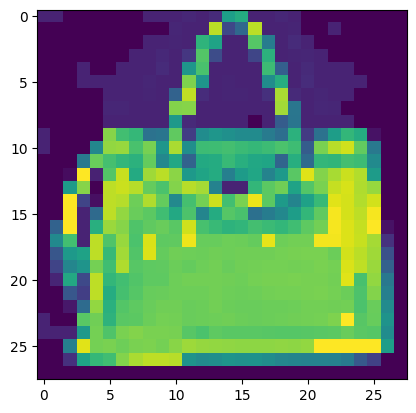


Here's what a 2-steps reconstructed sample looks like:



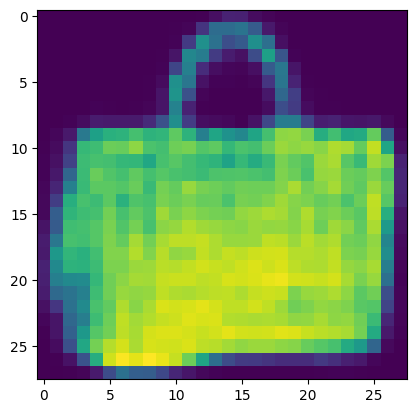

100%|██████████| 100/100 [00:02<00:00, 35.57it/s]


Epsilon: 0.1
Test Accuracy: 39.52%



In [82]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=2)

We see that using one step of top-down reconstruction from the generative model does not show a lot of improvement in the resilience to attacks, even though it is better performance compared to FFNN.

### Effect of the noise parameter $\epsilon$

In [83]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)  # set verbose to False to avoid displaying too many images
      accuracies.append(acc)

  return accuracies

In [85]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)

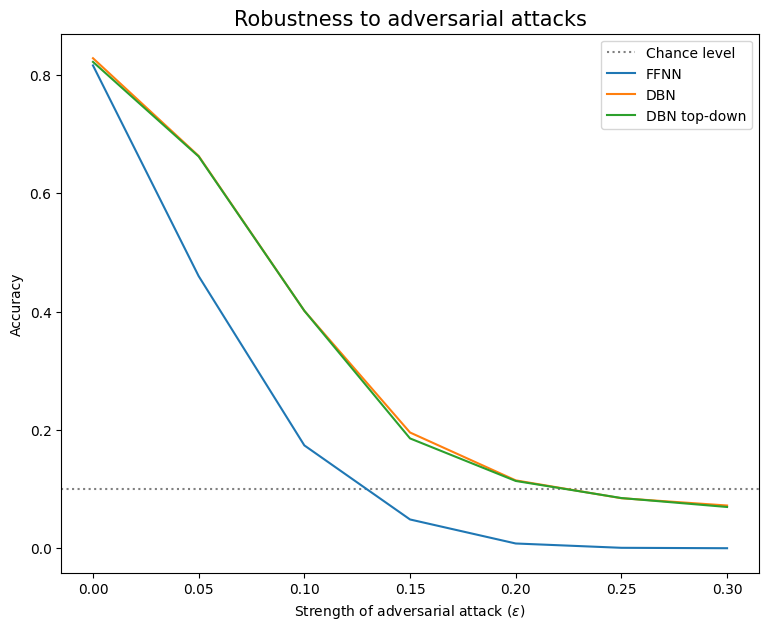

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])

The plot confirms our earlier observations: the FFNN performs worse than the DBN, and introducing a top-down reconstruction step does not significantly improve robustness.  

As expected, stronger adversarial attacks lead to weaker model resilience, causing accuracy to drop more sharply. This aligns with the idea that increasing perturbations make it harder for the models to recognize patterns, ultimately degrading their performance.

## Explore CNN

In the end, we explore how CNN deals with noise and adversarial attacks.

In [100]:
# Define the CNN architecture
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 3 * 3, 64)  # 64 channels, final feature map size 3x3
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [90]:
# Load Fashion-MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = tv.datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = tv.datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=125, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=126, shuffle=False)

In [102]:
# Initialize CNN model
cnn_model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Train the CNN
num_epochs = 20
cnn_model.train()
for epoch in range(num_epochs):
    for images, labels in tqdm.tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

Training Epoch 20: 100%|██████████| 480/480 [00:07<00:00, 63.91it/s]


In [103]:
# Evaluate CNN accuracy
cnn_model.eval()
def compute_accuracy(model, data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

cnn_accuracy = compute_accuracy(cnn_model, test_loader)
print(f"CNN Accuracy on Clean Data: {cnn_accuracy:.4f}")

CNN Accuracy on Clean Data: 0.9116


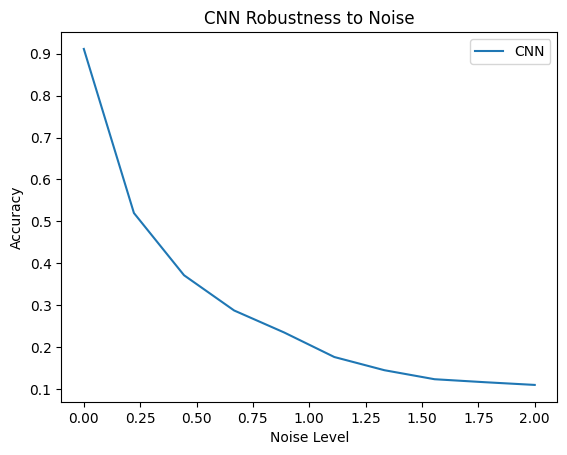

In [104]:
# Test CNN robustness to noise
def test_noise_robustness(model, noise_levels):
    accuracies = []
    for noise_level in noise_levels:
        noisy_loader = [(inject_noise(img, noise_level), lbl) for img, lbl in test_loader.dataset]
        noisy_loader = torch.utils.data.DataLoader(noisy_loader, batch_size=64, shuffle=False)
        acc = compute_accuracy(model, noisy_loader)
        accuracies.append(acc)
    return accuracies

noise_levels = np.linspace(0, 2, 10)
cnn_noise_accuracies = test_noise_robustness(cnn_model, noise_levels)

plt.plot(noise_levels, cnn_noise_accuracies, label="CNN")
plt.xlabel("Noise Level")
plt.ylabel("Accuracy")
plt.title("CNN Robustness to Noise")
plt.legend()
plt.show()

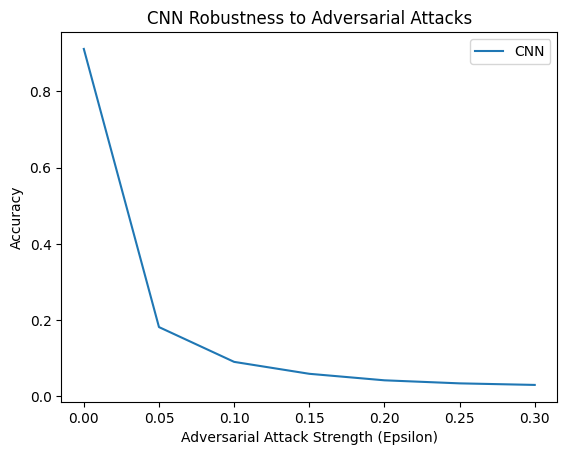

In [106]:
# Test CNN robustness to adversarial attacks
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = torch.clamp(image + epsilon * sign_data_grad, 0, 1)
    return perturbed_image

def test_adversarial_robustness(model, test_loader, epsilon):
    correct = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True
        outputs = model(images)
        loss = criterion(outputs, labels)
        model.zero_grad()
        loss.backward()
        perturbed_images = fgsm_attack(images, epsilon, images.grad.data)
        outputs = model(perturbed_images)
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == labels).sum().item()
    return correct / len(test_loader.dataset)

epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
cnn_attack_accuracies = [test_adversarial_robustness(cnn_model, test_loader, eps) for eps in epsilon_values]

plt.plot(epsilon_values, cnn_attack_accuracies, label="CNN")
plt.xlabel("Adversarial Attack Strength (Epsilon)")
plt.ylabel("Accuracy")
plt.title("CNN Robustness to Adversarial Attacks")
plt.legend()
plt.show()

The results show that as the noise level increases, the CNN's accuracy gradually declines, indicating that while it can handle small amounts of noise, it becomes highly unreliable under severe distortions. In contrast, adversarial attacks cause a much sharper drop in accuracy, even with small perturbations, highlighting the model’s vulnerability to targeted manipulations. This suggests that CNNs are more resilient to random noise than adversarial attacks, as the latter directly exploit weaknesses in the learned decision boundaries.

DBNs outperform FFNNs and CNNs in robustness to both noise and adversarial attacks. Against noise, deeper DBN layers retain higher accuracy, while FFNNs degrade faster. In adversarial attacks, DBNs, especially with top-down reconstruction, show greater resilience than FFNNs and CNNs, though all models experience a decline. CNNs handle noise better than FFNNs but worse than DBNs, while adversarial attacks severely impact their accuracy. Overall, DBNs demonstrate superior stability, likely due to their hierarchical feature learning and generative nature.